# 3.6 softmax回归的从零开始实现

In [8]:
import torch
import torchvision
import numpy as np
import sys
sys.path.append("..") # 为了导入上层目录的d2lzh_pytorch
import d2lzh_pytorch as d2l

print(torch.__version__)
print(torchvision.__version__)

1.9.1
0.10.1


## 3.6.1 获取和读取数据

In [13]:
batch_size = 256
def load_data_fashion_mnist(batch_size, resize=None, root='../../Datasets/FashionMNIST'):
    """Download the fashion mnist dataset and then load into memory."""
    trans = []
    if resize:
        trans.append(torchvision.transforms.Resize(size=resize))
    trans.append(torchvision.transforms.ToTensor())
    
    transform = torchvision.transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root=root, train=True, download=False, transform=transform)
    mnist_test = torchvision.datasets.FashionMNIST(root=root, train=False, download=False, transform=transform)
    if sys.platform.startswith('win'):
        num_workers = 0  # 0表示不用额外的进程来加速读取数据
    else:
        num_workers = 4
    train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_iter, test_iter

train_iter, test_iter = load_data_fashion_mnist(batch_size)

D:\anaconda3\envs\pytorch\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## 3.6.2 初始化模型参数

In [14]:
num_inputs = 784
num_outputs = 10

W = torch.tensor(np.random.normal(0, 0.01, (num_inputs, num_outputs)), dtype=torch.float)
b = torch.zeros(num_outputs, dtype=torch.float)

In [15]:
W.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True) 

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [16]:
X = torch.tensor([[1, 2, 3], [4, 5, 6]])
print(X.sum(dim=0, keepdim=True))
print(X.sum(dim=1, keepdim=True))

tensor([[5, 7, 9]])
tensor([[ 6],
        [15]])


## 3.6.3 实现softmax运算

In [17]:
def softmax(X):
    X_exp = X.exp()
    partition = X_exp.sum(dim=1, keepdim=True)
    return X_exp / partition  # 这里应用了广播机制

In [18]:
X = torch.rand((2, 5))
X_prob = softmax(X)
print(X_prob, X_prob.sum(dim=1))

tensor([[0.2305, 0.2831, 0.2085, 0.1608, 0.1171],
        [0.1287, 0.2031, 0.1301, 0.3094, 0.2286]]) tensor([1., 1.])


## 3.6.4 定义模型

In [19]:
def net(X):
    return softmax(torch.mm(X.view((-1, num_inputs)), W) + b)

## 3.6.5 定义损失函数

In [20]:
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y = torch.LongTensor([0, 2])
y_hat.gather(1, y.view(-1, 1))

tensor([[0.1000],
        [0.5000]])

In [21]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat.gather(1, y.view(-1, 1)))

## 3.6.6 计算分类准确率

In [22]:
def accuracy(y_hat, y):
    return (y_hat.argmax(dim=1) == y).float().mean().item()

In [23]:
print(accuracy(y_hat, y))

0.5


In [24]:
# 本函数已保存在d2lzh_pytorch包中方便以后使用。该函数将被逐步改进：它的完整实现将在“图像增广”一节中描述
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
        n += y.shape[0]
    return acc_sum / n

In [25]:
print(evaluate_accuracy(test_iter, net))

0.0286


## 3.6.7 训练模型

In [27]:
num_epochs, lr = 5, 0.1

# 本函数已保存在d2lzh_pytorch包中方便以后使用
def train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size,
              params=None, lr=None, optimizer=None):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y).sum()
            
            # 梯度清零
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            
            l.backward()
            if optimizer is None:
                print("第%d个epoch没有优化器，现在为其添加sgd" %(epoch+1))
                d2l.sgd(params, lr, batch_size)
            else:
                print("第%d个epoch有优化器，直接计算step,更新所有参数" %(epoch+1))
                optimizer.step()  # “softmax回归的简洁实现”一节将用到
            
            
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]   # 样本数
            print("batch_size 是否等于n：%d"%(batch_size == n))
            print("y.shape[0]为：%d"%(n))
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))

train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, batch_size, [W, b], lr)

第1个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：1
y.shape[0]为：256
第1个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：512
第1个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：768
第1个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：1024
第1个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：1280
第1个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：1536
第1个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：1792
第1个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：2048
第1个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：2304
第1个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：2560
第1个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：2816
第1个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：3072
第1个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：3328
第1个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：3584
第1个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：3840
第1个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：4096
第1个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0


第1个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：35328
第1个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：35584
第1个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：35840
第1个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：36096
第1个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：36352
第1个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：36608
第1个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：36864
第1个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：37120
第1个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：37376
第1个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：37632
第1个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：37888
第1个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：38144
第1个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：38400
第1个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：38656
第1个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：38912
第1个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：39168
第1个epoch没有优化器，现在为其添加sgd


batch_size 是否等于n：0
y.shape[0]为：9984
第2个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：10240
第2个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：10496
第2个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：10752
第2个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：11008
第2个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：11264
第2个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：11520
第2个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：11776
第2个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：12032
第2个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：12288
第2个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：12544
第2个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：12800
第2个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：13056
第2个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：13312
第2个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：13568
第2个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：13824
第2个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shap

batch_size 是否等于n：0
y.shape[0]为：45312
第2个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：45568
第2个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：45824
第2个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：46080
第2个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：46336
第2个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：46592
第2个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：46848
第2个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：47104
第2个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：47360
第2个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：47616
第2个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：47872
第2个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：48128
第2个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：48384
第2个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：48640
第2个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：48896
第2个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：49152
第2个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.sha

第3个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：20736
第3个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：20992
第3个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：21248
第3个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：21504
第3个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：21760
第3个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：22016
第3个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：22272
第3个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：22528
第3个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：22784
第3个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：23040
第3个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：23296
第3个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：23552
第3个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：23808
第3个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：24064
第3个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：24320
第3个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：24576
第3个epoch没有优化器，现在为其添加sgd


batch_size 是否等于n：0
y.shape[0]为：55040
第3个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：55296
第3个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：55552
第3个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：55808
第3个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：56064
第3个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：56320
第3个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：56576
第3个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：56832
第3个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：57088
第3个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：57344
第3个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：57600
第3个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：57856
第3个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：58112
第3个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：58368
第3个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：58624
第3个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：58880
第3个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.sha

batch_size 是否等于n：0
y.shape[0]为：29440
第4个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：29696
第4个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：29952
第4个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：30208
第4个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：30464
第4个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：30720
第4个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：30976
第4个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：31232
第4个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：31488
第4个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：31744
第4个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：32000
第4个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：32256
第4个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：32512
第4个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：32768
第4个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：33024
第4个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：33280
第4个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.sha

batch_size 是否等于n：0
y.shape[0]为：3584
第5个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：3840
第5个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：4096
第5个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：4352
第5个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：4608
第5个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：4864
第5个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：5120
第5个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：5376
第5个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：5632
第5个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：5888
第5个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：6144
第5个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：6400
第5个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：6656
第5个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：6912
第5个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：7168
第5个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：7424
第5个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：7680
第5个e

第5个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：38656
第5个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：38912
第5个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：39168
第5个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：39424
第5个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：39680
第5个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：39936
第5个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：40192
第5个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：40448
第5个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：40704
第5个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：40960
第5个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：41216
第5个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：41472
第5个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：41728
第5个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：41984
第5个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：42240
第5个epoch没有优化器，现在为其添加sgd
batch_size 是否等于n：0
y.shape[0]为：42496
第5个epoch没有优化器，现在为其添加sgd


## 3.6.8 预测

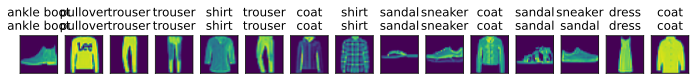

In [30]:
X, y = iter(test_iter).next()

true_labels = d2l.get_fashion_mnist_labels(y.numpy())
pred_labels = d2l.get_fashion_mnist_labels(net(X).argmax(dim=1).numpy())
titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]

d2l.show_fashion_mnist(X[0:15], titles[0:15])

In [29]:
X.shape

torch.Size([256, 1, 28, 28])